In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 7]

# DC Motor simulation
## Parameters
### Motor
[Maxon DCX 22 EB KL 12V](https://www.maxongroup.com/medias/sys_master/root/8881021878302/EN-21-101.pdf)
11/20 W, 29.8 mNm, 7160 rpm

In [2]:
Maxon_RotorInertia = 9.0 # gcm2
Maxon_SpeedConstant = 416 # rpm/V
Maxon_TorqueConstant = 22.9 # mNm/A
Maxon_TerminalResistance = 1.84 # Ohms
Maxon_TerminalInductance = 0.198 # mH

Maxon_NominalCurrent = 1.3 # A
Maxon_NominalTorque = 29.5 # mMm
Maxon_StallCurrent = 6.54 # A

Maxon_MechanicalTimeConstant = 3.14e-3 # s

# No load speed = 4980 rpm (12V)
Maxon_NoLoadSpeed = 4080 # rpm
Maxon_NoLoadCurrent = 20e-3 # A

Added Toroidal Inductance to limit dc motor iron losses

In [3]:
Seabot_AddedInductance = 1.619e-3 # H
Seabot_AddedInductanceResistance = 480e-3 # Ohms

Parameters of the DC model
https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling

https://aleksandarhaber.com/modeling-a-dc-motor-and-matlab-simulation/

In [4]:
rpm_to_rad_s = np.pi/30.
J = Maxon_RotorInertia * 1e-7 # Moment of inertia (kg.m^2)
Ke = 1./(Maxon_SpeedConstant*rpm_to_rad_s) # Electromotive force constant  (V/rad/sec)
Kt = Maxon_TorqueConstant*1e-3 # Motor torque constant (N.m/Amp)
R = Maxon_TerminalResistance + Seabot_AddedInductanceResistance # Electric resistance (Ohm)
L = Maxon_TerminalInductance*1e-3 + Seabot_AddedInductance # Electric inductance (H)
#Tfdyn = Maxon_TorqueConstant*1e-3*Maxon_NoLoadCurrent/(Maxon_NoLoadSpeed*rpm_to_rad_s)

### Reductor
[GPX22UP 103:1](https://www.maxongroup.com/medias/sys_master/root/8882582683678/EN-21-352.pdf)
3 stages

In [5]:
Maxon_Reduction = 103 # 103:1
Maxon_MaxContinuousTorque = 4.3 # Nm
Maxon_MassInertia = 0.6 # gcm2

### Endless Screw System

In [6]:
Screw_Thread = 1e-3 # m
Screw_Radius = 6e-3 # m
Screw_FrictionCoefficient = 0.2 # To be correctly evaluated ! Copper-Copper = 1.2
Piston_diam = 45e-3 # m

rad_to_pulses = 2048 * 4 / Maxon_Reduction # to convert a rad in pulse

### Environement

In [7]:
rho = 1025 # kg/m3
g = 9.81 # m/s-3
z_max = 100 # m

In [8]:
sensor_current_sensitivity = 264e-3 #66e-3 # V/A
dspic_adc_resolution = 1<<12 # resolution
dspic_adc_vcc = 3.3 # V
current_to_adc = sensor_current_sensitivity*dspic_adc_resolution/dspic_adc_vcc

## First validation
* Compute the torque at requiered at 100m

In [9]:
pistonSurface = np.pi*(Piston_diam/2.)**2
force100 = pistonSurface*rho*g*z_max
print('Force at 100 m = {:.2f} N'.format(force100))

i_screw=Screw_Thread/(2*Screw_Radius) # Note : error in the thesis formula : diam and not radius
force_to_torque_coeff = Screw_Radius*np.tan(Screw_FrictionCoefficient+i_screw)
torque100 = force_to_torque_coeff*force100
print('Torque at 100 m = {:.2f} Nm'.format(torque100))

weight100 = force100/g
print('Equivalent in kg for test at 100m : {:.2f} kg'.format(weight100))

Force at 100 m = 1599.22 N
Torque at 100 m = 2.79 Nm
Equivalent in kg for test at 100m : 163.02 kg


* Maximum torque at the output of the moto-reductor

In [10]:
max_torque_maxon = Maxon_NominalTorque*1.e-3*Maxon_Reduction
print('Nominal Torque (output reductor) = {:.2f} Nm'.format(max_torque_maxon))

Tz_coeff = pistonSurface*rho*g* force_to_torque_coeff / Maxon_Reduction
Tz_at_100 = Tz_coeff*100
print('Torque at 100 (output motor) = {:.2f} Nm'.format(Tz_at_100))

Tfstatic = Kt*20e-3 # constant friction of the system : 20mA 
print('Torque friction = {:.2f} mNm'.format(Tfstatic*1e3))

Nominal Torque (output reductor) = 3.04 Nm
Torque at 100 (output motor) = 0.03 Nm
Torque friction = 0.46 mNm


## Simulation
$J\ddot{\theta}=K_{t}i-T_{d}\left(\dot{\theta},i\right)-T_{z}\left(\dot{\theta},i\right)$

$L\dot{i}+Ri=V-K_e\dot\theta$

$\frac{d}{dt}\left(\begin{array}{c}
\theta\\
\dot{\theta}\\
i
\end{array}\right)=\left(\begin{array}{ccc}
0 & 1 & 0\\
0 & 0 & \frac{K_{t}}{J}\\
0 & \frac{-K_{e}}{L} & \frac{-R}{L}
\end{array}\right)\left(\begin{array}{c}
\theta\\
\dot{\theta}\\
i
\end{array}\right)+\left(\begin{array}{c}
0\\
0\\
\frac{1}{L}
\end{array}\right)V+\left(\begin{array}{c}
0\\
-\frac{T_{z}\left(\dot{\theta},i\right)}{J}-\frac{T_{d}\left(\dot{\theta},i\right)}{J}\\
0
\end{array}\right)$

In [45]:
A = np.array([[0., 1., 0.],[0., 0., Kt/J], [0., -Ke/L,-R/L]])
B = np.array([0.0,0.,1./L])
print('A = ', A)
print('B = ', B)

A =  [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.54444444e+04]
 [ 0.00000000e+00 -1.26334837e+01 -1.27682994e+03]]
B =  [  0.           0.         550.35773253]
25444.444444444445 25444.444444444445


State space : $x = \begin{bmatrix}\theta \\ \dot\theta \\ i\end{bmatrix}$
Input : $u = \begin{bmatrix}V\end{bmatrix}$ 

In [76]:
def f(x, V, z):
    # Approximation : we do not consider precisly the case where dtheta cross zero
    i = x[2]
    dtheta = x[1]
    if(dtheta==0):
        Td = np.sign(Kt*i)*min(abs(Kt*i), Tfstatic)
        Tz = min(abs(Kt*i-Td), z*Tz_coeff) if (Kt*i-Td)>0 else 0.
    else:
        Td = np.sign(x[1])*Tfstatic
        Tz = z*Tz_coeff if np.sign(x[1])>0 else 0.
        
    C = np.array([0, -(Tz+Td)/J, 0])
    
    return (A @ x) + (B * V) + C

def euler(x, V, z, dt):
    
    dx = f(x, V, z)
    x_new = x + dx*dt
    
    print(x_new)
    
    # Case where dtheta cross zero
    # We have to find t such that
    #print(x[1], x_new[1])
    if(np.sign(x[1])!=np.sign(x_new[1]) and np.sign(x[1])!=0):
        dt2 = -x[1]/dx[1]
        x_new1 = x + dx*dt2
        
        dx2 = f(x_new1, V, z)
        x_new1 += dx2*(dt-dt2)
        
        if(np.sign(x_new[1])==np.sign(x[1])):
           print("possible oscillation", x_new[1], x[1])
        return x_new1
    else:
        return x_new

###########################################
# Test integration
x = np.array([0., 0., 0.0])
V = 0.1
z = 100

# Test stop
#x = np.array([0., 350., 0.0])
#u = np.array([-12, 100.]) # V, m

dt = 1e-5
tmax = 10*dt #0.002
result_x = np.array((0, x[0], x[1], x[2]))

for t in np.arange(dt, tmax, dt):
    x = euler(x, V, z, dt)
    
    result_x = np.vstack([result_x, np.array((t, x[0], x[1], x[2]))])
    

[0.         0.         0.00055036]
[0.         0.         0.00109369]
[0.         0.         0.00163008]
[0.         0.         0.00215963]
[ 0.00000000e+00 -7.10542736e-20  2.68240887e-03]
[-7.10542736e-25  5.77141292e-03  3.19851680e-03]
[-8.74778821e-42  0.00000000e+00  3.70803492e-03]
[-8.74778821e-42 -1.42108547e-19  4.21104735e-03]
[-1.42108547e-24  6.16036649e-03  4.70763717e-03]


i_max = 0.005 A
i_end = 0.005 A
dtheta = 0.000 rad/s
theta_end = -0.000 pulses


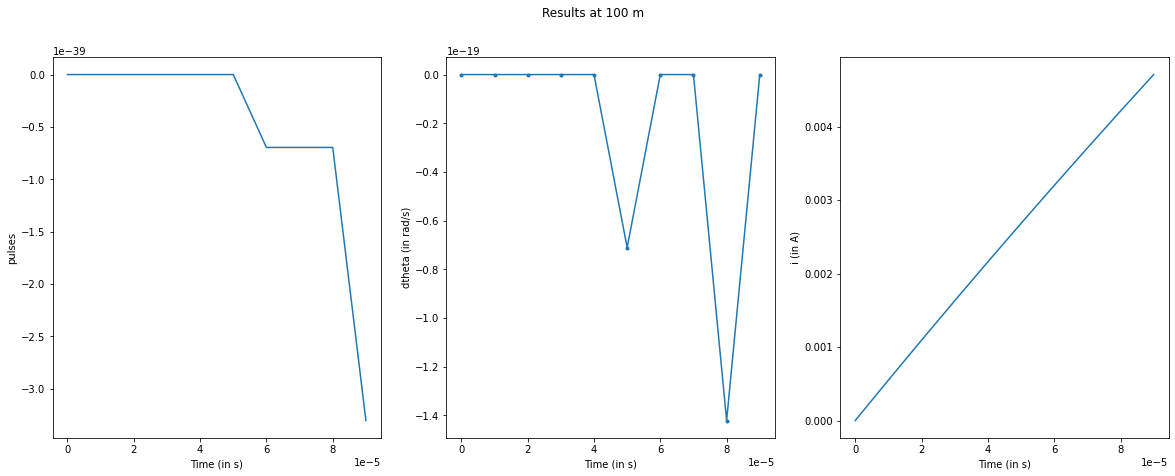

In [77]:
# Display
fig, axs = plt.subplots(1,3)
fig.suptitle('Results at ' + str(z) + ' m')
axs[0].plot(np.transpose(result_x)[0], (np.transpose(result_x)[1]*rad_to_pulses))
axs[0].set_xlabel('Time (in s)')
axs[0].set_ylabel('pulses')

axs[1].plot(np.transpose(result_x)[0], np.transpose(result_x)[2], ".-")
axs[1].set_xlabel('Time (in s)')
axs[1].set_ylabel('dtheta (in rad/s)')

axs[2].plot(np.transpose(result_x)[0], np.transpose(result_x)[3])
axs[2].set_xlabel('Time (in s)')
axs[2].set_ylabel('i (in A)')

# Analysis
result_i = np.transpose(result_x)[3]

print('i_max = {:.3f} A'.format(np.max(result_i)))
print('i_end = {:.3f} A'.format(result_i[-1]))
print('dtheta = {:.3f} rad/s'.format(np.max(np.transpose(result_x)[2])))
print('theta_end = {:.3f} pulses'.format(np.max(np.transpose(result_x)[1][-1]*rad_to_pulses)))

# Max dtheta at 100m = 400 rad/s

i_max = 416 bit
i_end = 394 bit
i_max_adc (12 bit) = 4095 bit


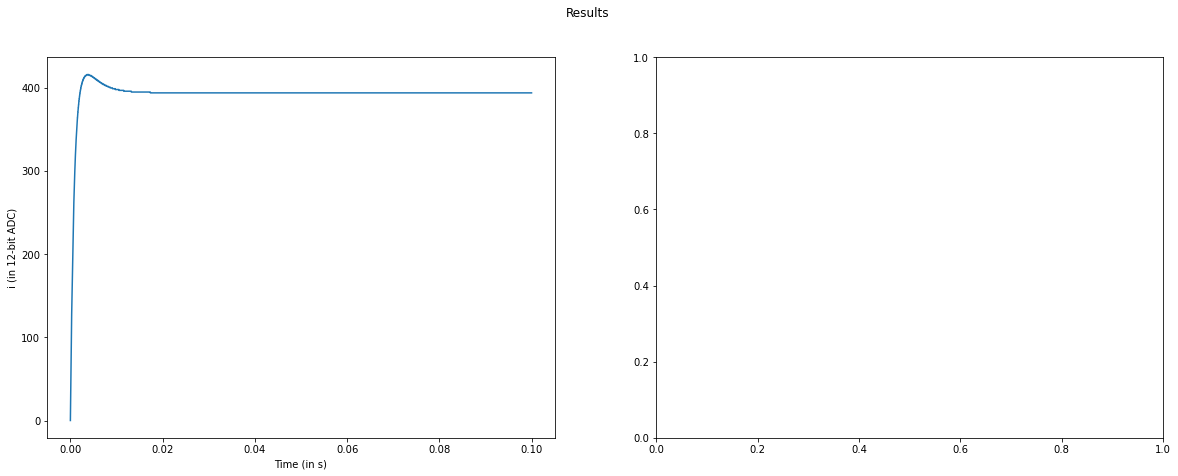

In [14]:
result_i_adc = np.floor(result_i*current_to_adc)

fig, axs = plt.subplots(1,2)
fig.suptitle('Results')
axs[0].plot(np.transpose(result_x)[0], result_i_adc)
axs[0].set_xlabel('Time (in s)')
axs[0].set_ylabel('i (in 12-bit ADC)')

print('i_max = {:g} bit'.format(np.max(result_i_adc)))
print('i_end = {:g} bit'.format(result_i_adc[-3]))
print('i_max_adc (12 bit) = {:g} bit'.format(2**12-1))

## Regulation
$V=-\frac{JL}{K_{t}}\left(\gamma\frac{\ddot{\theta}D-\dot{\theta}\dot{D}}{D^{2}}-2s\dot{y}+s^{2}y\right)+K_{e}\dot{\theta}+Ri$

In [15]:
def plot_results():
    global result_x, result_debug
    # Display
    fig, (axs1, axs2) = plt.subplots(2,2)
    fig.suptitle('Results')
    axs1[0].plot(np.transpose(result_x)[0], np.transpose(result_x)[1]*rad_to_pulses)
    axs1[0].set_xlabel('Time (in s)')
    #axs1[0].set_ylabel('theta (in rad)')
    axs1[0].set_ylabel('pulses')

    axs1[1].plot(np.transpose(result_x)[0], np.transpose(result_x)[2])
    axs1[1].set_xlabel('Time (in s)')
    axs1[1].set_ylabel('dtheta (in rad/s)')

    axs2[0].plot(np.transpose(result_x)[0], result_i)
    axs2[0].set_xlabel('Time (in s)')
    axs2[0].set_ylabel('i (in A)')

    axs2[1].plot(np.transpose(result_x)[0], np.transpose(result_x)[4])
    axs2[1].set_xlabel('Time (in s)')
    axs2[1].set_ylabel('V')

    # Analysis
    print('i_max = {:.3f} A'.format(np.max(result_i)))
    print('i_end = {:.3f} A'.format(result_i[-3]))
    print('dtheta = {:.3f} rad/s'.format(np.max(np.transpose(result_x)[2])))
    print('theta_max = {:.3f} pulses'.format(np.max((np.transpose(result_x)[1]*rad_to_pulses))))
    print('theta_end = {:.3f} pulses'.format((np.transpose(result_x)[1]*rad_to_pulses)[-1]))
    print('V_max = {:.3f} V'.format(np.max(np.transpose(result_x)[4])))
    print('V_end = {:.3f} V'.format((np.transpose(result_x)[4])[-1]))

    # 2nd graph
    fig2, (axs3, axs4) = plt.subplots(2,3)
    fig2.suptitle('Regulation')

    axs3[0].plot(np.transpose(result_x)[0], np.transpose(result_debug)[0])
    axs3[0].set_xlabel('Time (in s)')
    axs3[0].set_ylabel('y')

    axs3[1].plot(np.transpose(result_x)[0], np.transpose(result_debug)[1])
    axs3[1].set_xlabel('Time (in s)')
    axs3[1].set_ylabel('dy')

    axs3[2].plot(np.transpose(result_x)[0], np.transpose(result_debug)[2])
    axs3[2].set_xlabel('Time (in s)')
    axs3[2].set_ylabel('ddy')

    axs4[0].plot(np.transpose(result_x)[0], np.transpose(result_debug)[3])
    axs4[0].set_xlabel('Time (in s)')
    axs4[0].set_ylabel('z')

i_max = 1.305 A
i_end = 1.223 A
dtheta = 348.733 rad/s
theta_max = 10711.763 pulses
theta_end = 10711.763 pulses
V_max = 15.861 V
V_end = 15.861 V


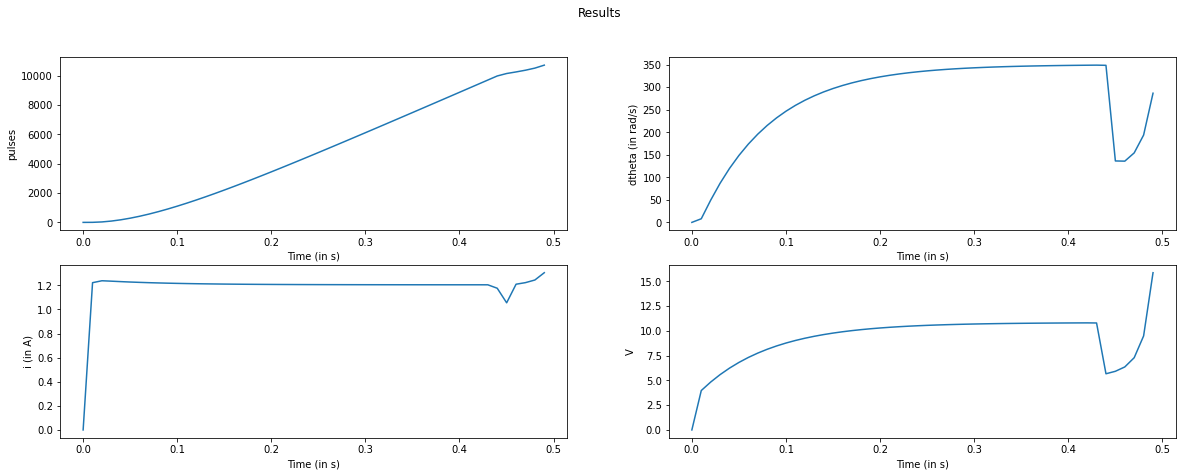

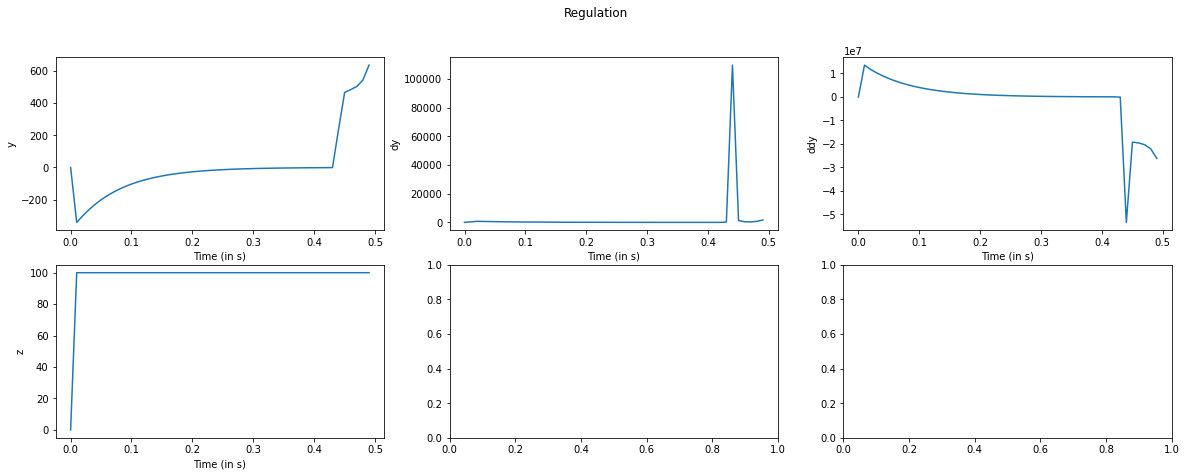

In [16]:
def regulation_arctan(theta_set_point, x, z):
    global Kt, Tz, J, Tz, R, Tf, result_debug, alpha, beta
    s = -1/0.005
    
    gamma = beta/alpha
    theta = x[0]
    dtheta = x[1]
    i = x[2]
    
    e = (1./alpha)*(theta_set_point - theta)
    D = (1+e**2)
    dD = -2*e*dtheta/(alpha**2)
    
    Tz = Tz_coeff
    if(x[1]<=0): # Case where the piston goes in
        Tz = 0
        
    ddtheta = (Kt*i-z*Tz-Tf*np.sign(dtheta))/J
    
    y = dtheta-beta*np.arctan(e)
    dy = ddtheta+gamma*dtheta/D
    
    V=-(J*L/Kt)*(gamma*(ddtheta*D-dtheta*dD)/(D**2)-Tf*ddtheta/J-2*s*dy+s**2*y)+Ke*dtheta+R*i    
    
    ddy = (Kt/(J*L))*(V-Ke*dtheta-R*i)-Tf*ddtheta/J+gamma*((ddtheta*D-dtheta*dD)/D**2)
    result_debug = np.vstack([result_debug, np.array((y, dy,ddy, z))])
    return V

def regulation_tanh(theta_set_point, x, z):
    global Kt, Tz_coeff, J, R, Tfstatic, result_debug, alpha, beta
    s = -1/0.005

    theta = x[0]
    dtheta = x[1]
    i = x[2]
    
    e=alpha*(theta_set_point-theta)
    T=np.tanh(e)
    gamma = beta*alpha
    de=-alpha*dtheta
    
    Tz = Tz_coeff
    #if(x[1]<=0): # Case where the piston goes in
    #    Tz = 0
    
    ddtheta = (Kt*i-z*Tz-Tfstatic*np.sign(dtheta))/J
    
    y = dtheta - beta*T
    dy = ddtheta - beta*de*(1-T**2)
    
    V = Ke*dtheta + R*i - (J*L/Kt)*(gamma*(ddtheta*(1-T**2)-2*dtheta*de*(T-T**2))-2*s*dy+s**2*y)
    
    dddtheta = (Kt/(J*L))*(V-Ke*dtheta-R*i)
    ddy = dddtheta+gamma*(ddtheta*(1-T**2)-2*dtheta*de*(T-T**2))
    result_debug = np.vstack([result_debug, np.array((y, dy,ddy, z))])
    return V

    
x = np.array([0., 0., 0.0])
z = 100

dt_euler = 1e-4 #1e-5
dt_regulation = 1/100.
tmax = 0.5 #0.05
result_x = np.array((0, x[0], x[1], x[2], 0))
theta_set_point = 10000 /rad_to_pulses
t_last_regulation = 0
store_value = False

v_limit = 350 # rad/s
v_slope = 4 # rad/s

#beta = v_limit * 2./np.pi # 350 rad/s
#alpha = beta/v_slope

alpha = 1
beta = 350

result_debug = np.array((0, 0, 0, 0))

for t in np.arange(dt_euler, tmax, dt):
    if(t-t_last_regulation >= dt_regulation):
        #V = regulation_arctan(theta_set_point, x, z)
        V = regulation_tanh(theta_set_point, x, z)
        
        t_last_regulation = t
        store_value = True
    x+=f(x, V, z)*dt
    
    
    if(store_value):
        result_x = np.vstack([result_x, np.array((t, x[0], x[1], x[2], V))])
        store_value = False
    
result_i = np.transpose(result_x)[3]
plot_results()
    



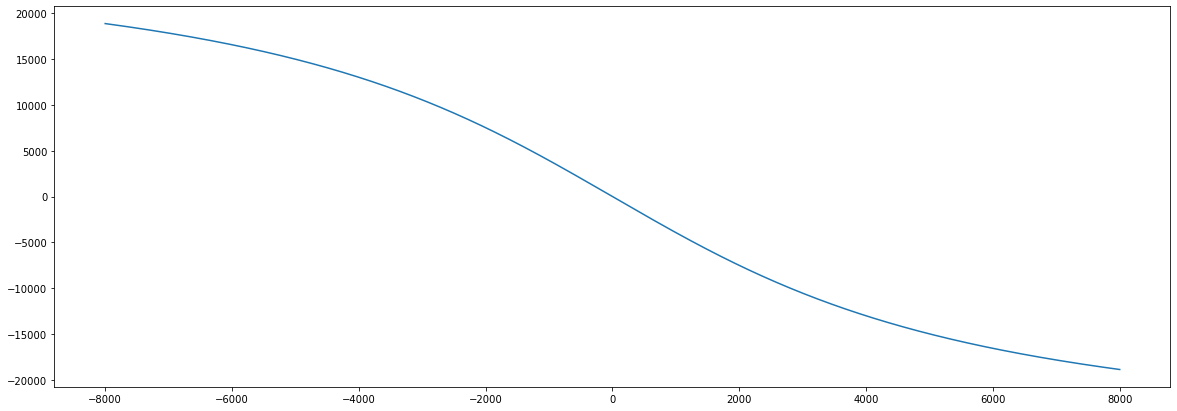

In [17]:
v_limit = 350 # rad/s
v_slope = 4 # rad/s

beta = v_limit * 2./np.pi # 350 rad/s
alpha = beta/v_slope

theta = np.linspace(-8000/rad_to_pulses, 8000/rad_to_pulses, num=2000)
dtheta = beta*np.arctan(-theta/alpha)
plt.plot(theta*rad_to_pulses, dtheta*rad_to_pulses)

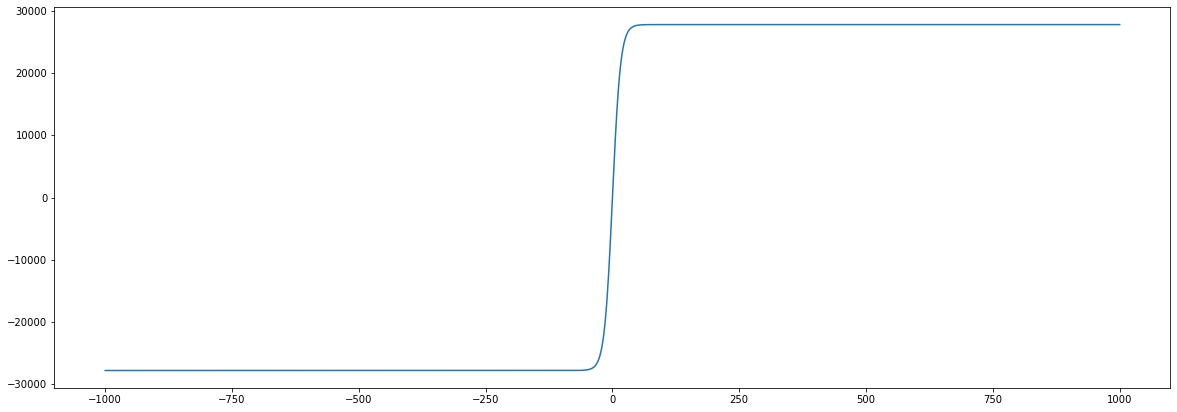

In [18]:
def sigmoid(x, alpha, beta):
    return beta*(2./(1+np.exp(-2*alpha/beta*x))-1)

def sigmoid2(x, alpha, beta):
    return beta*np.tanh(alpha*x/beta)

def sigmoid3(x, alpha, beta):
    return beta*np.tanh(alpha*x)

theta = np.linspace(-1000/rad_to_pulses, 1000/rad_to_pulses, num=2000)
#dtheta =sigmoid(theta, 1, 350)
dtheta =sigmoid3(theta, 5, 350)
plt.plot(theta*rad_to_pulses, dtheta*rad_to_pulses)

